# ProtoECGNet Case-Based Explanations

This notebook provides example code for generating case-based explanations using specific branches of ProtoECGNet. This code is not directly compatible with the fusion weights, so you should train branch-specific classifiers for the models you use here. 

Therefore, to generate a case-based explanation for a specific target ECG: 
 - You should determine which classes are predicted by the fusion classifier and which associated prototypes are most activated using our inference_fusion.py file. 
 - Then, use this code to generate figures by inputing the target ECG number and prototype number in the user inputs below using the correct sub-branch (i.e. if the fusion classifier predicts A-fib, use the 1D branch below; if it predicts ASMI, use the 2D partial prototype branch below)
 - If there are multiple predictions in different branches, produce the explantions one-by-one

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from ecg_utils import get_dataloaders, load_label_mappings
from training_functions import seed_everything
from proto_models1D import ProtoECGNet1D
from proto_models2D import ProtoECGNet2D
from backbones import resnet1d18, resnet18

### User Inputs

In [ ]:
seed = 42
seed_everything(seed)

rand_ecg = False #select True to do inference on a random ECG, otherwise select False
target_ecg_id = 65 #ignored if rand_ecg is True
dimension = '2D'  # or '2D'
label_set = '3'  # adjust as needed
custom_groups = True
sampling_rate = 100
backbone = 'resnet1d18' if dimension == '1D' else 'resnet18'
target_prototype = 151 # for 2D partial only, this is the number of the target prototype that you want to use when determining what window to highlight on the test ECG

#Category 1
#pretrained_weights = '/path/to/cat1_1D_branch_weights.ckpt'
#json_path = '/path/to/cat1_1D_branch_prototype_metadata.json'

#Category 3
pretrained_weights = '/path/to/cat3_2D_partial_branch_weights.pth'
json_path = '/path/to/cat3_2D_partial_branch_prototype_metadata.json'

#Category 4
#pretrained_weights = '/path/to/cat4_2D_global_branch_weights.pth
#json_path = '/path/to/cat4_2D_global_branch_prototype_metadata.json'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
proto_time_len=3 # 3 for cat3, 32 for cat4; unused for cat1
prototypes_per_class=7 #5 for cat1, 18 for cat3, 7 for cat4
batch_size = 32 
top_k = 5

# Load your projection file
with open(json_path, "r") as f:
    prototype_metadata = json.load(f)

# Count how many prototypes were projected
num_projected = len(prototype_metadata)
print(f"Total projected prototypes: {num_projected}")


Seed set to 42


Total projected prototypes: 936


#### Get dataloaders and label mappings

In [3]:
train_loader, val_loader, test_loader, class_weights = get_dataloaders(
        batch_size=batch_size, 
        mode=dimension,
        sampling_rate=100, 
        label_set=label_set,
        work_num=0,
        return_sample_ids=True,
        custom_groups=custom_groups, 
        standardize=False,
        remove_baseline=True,
)

print("Loading label mappings...")
label_mappings = load_label_mappings(
    custom_groups=custom_groups,
    prototype_category=int(label_set) if custom_groups else None
)

if custom_groups:
    num_classes = len(label_mappings["custom"])
else:
    num_classes = len(label_mappings[label_set])

label_mapping = {i: label_mappings['custom'][i] for i in range(len(label_mappings['custom']))}

Loaded 52 custom group labels (Category: 3)
Final retained samples: 17418/17418
Loaded 52 custom group labels (Category: 3)
Final retained samples: 2183/2183
Loaded 52 custom group labels (Category: 3)
Final retained samples: 2198/2198


/Users/sahilsethi/Desktop/ECG_project/protoecgnet/src/ecg_utils.py:368: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(class_weights, dtype=torch.float32)



--- Data Summary ---
Training set: 17418 samples, Validation set: 2183 samples, Test set: 2198 samples
Loaded training data: X_train shape: (17418, 1000, 12), y_train shape: (17418, 52)
Loaded validation data: X_val shape: (2183, 1000, 12), y_val shape: (2183, 52)
Loaded test data: X_test shape: (2198, 1000, 12), y_test shape: (2198, 52)
Label distribution (Train): [1461.  615.   94. 2143. 1887. 1708. 1298. 1019.  894.  527.  432.  428.
  383.  341.  282.  232.  175.  171.  161.  143.  141.  135.  116.  113.
  102.   84.   79.   64.   62.   41.   35.   26.   24.   14.   13.   13.
   11. 2683.  915.  807.  701.  438.  350.  340.  318.  272.  235.  145.
   49.   28.   22.    8.]
Label distribution (Validation): [182.  75.  12. 266. 236. 210. 163. 125. 112.  66.  55.  54.  47.  43.
  36.  29.  21.  21.  20.  18.  18.  17.  15.  14.  12.  10.  10.   7.
   7.   5.   5.   4.   3.   2.   2.   2.   2. 322. 114. 101.  87.  55.
  44.  41.  40.  34.  30.  19.   7.   4.   3.   1.]
Label distribut

#### Load the model

In [4]:
common_kwargs = dict(
    num_classes=num_classes,
    single_class_prototype_per_class=prototypes_per_class,
    joint_prototypes_per_border=0,
    proto_dim=512,
    prototype_activation_function='log',
    latent_space_type='arc',
    add_on_layers_type='linear',
    class_specific=True,
    last_layer_connection_weight=1.0,
    m=0.05,
    dropout=0,
    custom_groups=custom_groups,
    label_set=label_set,
    pretrained_weights=pretrained_weights,
)

if dimension == '1D':
    model = ProtoECGNet1D(backbone=backbone, **common_kwargs).to(device)
elif dimension == '2D':
    model = ProtoECGNet2D(proto_time_len=proto_time_len, backbone=backbone, **common_kwargs).to(device)
else:
    raise ValueError("dimension must be '1D' or '2D'")


[INFO] Loaded label co-occurrence matrix from /Users/sahilsethi/Desktop/ECG_project/physionet.org/files/ptb-xl/1.0.3/preprocessing/label_cooccur_Cat3.pt with shape torch.Size([52, 52])
Initializing ProtoECGNet2D with backbone resnet18...
Full ProtoECGNet2D checkpoint detected. Skipping backbone-only loading...
Initialized prototype_vectors with shape: (364, 512, 1, 3)
Updated classifier weight matrix: Correct = 1.0, Incorrect = -0.5
Now loading full model from /Users/sahilsethi/Desktop/ECG_project/final_results/cat3_contrastive_epoch=34-val_auc=0.8691.ckpt
Checkpoint contains 936 prototypes. Adjusting model initialization.


### Define helper functions

In [5]:
def get_test_sample_by_id(test_loader, target_id):
    """
    Retrieve a specific ECG sample from the test_loader by ecg_id.
    Returns: (sample_x, sample_y, sample_id) or raises ValueError if not found.
    """
    for X_batch, y_batch, id_batch in test_loader:
        for x, y, ecg_id in zip(X_batch, y_batch, id_batch):
            if int(ecg_id.item()) == target_id:
                return x, y, ecg_id.item()
    raise ValueError(f"ECG ID {target_id} not found in the test set.")


def get_random_test_sample(test_loader):
    """Returns a random test ECG from the DataLoader."""
    test_iter = iter(test_loader)
    batch = next(test_iter)  # Get the first batch
    X_batch, y_batch, sample_ids = batch
    idx = random.randint(0, len(X_batch) - 1)  # Select a random sample

    return X_batch[idx], y_batch[idx], sample_ids[idx]

# Function to run inference on a single sample
def run_inference(model, X_sample):
    """Runs inference on a single ECG sample and extracts prototype activations."""
    X_sample = X_sample.unsqueeze(0).to('cpu')  # Add batch dimension and move to GPU
    model.eval()
    with torch.no_grad():
        logits, _, similarity_scores = model(X_sample)  # Run inference
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()  # Convert logits to probabilities
    similarity_scores = similarity_scores.cpu().numpy().flatten()  # Prototype activations
    return probabilities, similarity_scores

def plot_ecg(
    raw_ecg,
    sampling_rate=100,
    ecg_id=None,
    true_labels=None,
    prototype_labels=None,
    predicted_labels=None,
    rhythm_strip1='II',
    rhythm_strip2=None,
    rhythm_strip3=None,
    prototype_idx=None,
    similarity_score=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    if raw_ecg.shape == (12, 1000):
        raw_ecg = raw_ecg.T
    assert raw_ecg.shape == (1000, 12)

    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    lead_name_to_idx = {name: i for i, name in enumerate(lead_names)}

    rhythm_leads = []
    for lead in [rhythm_strip1, rhythm_strip2, rhythm_strip3]:
        if lead is not None:
            lead_str = lead if isinstance(lead, str) else lead[0]  
            rhythm_leads.append(lead_name_to_idx[lead_str])

    mm_per_mv = 10
    mm_per_sec = 25
    paper_speed = mm_per_sec
    gain = mm_per_mv

    duration = raw_ecg.shape[0] / sampling_rate
    stacked_leads = [
        ['I', 'aVR', 'V1', 'V4'],
        ['II', 'aVL', 'V2', 'V5'],
        ['III', 'aVF', 'V3', 'V6']
    ]

    num_rows = len(stacked_leads) + len(rhythm_leads)
    row_spacing_mm = 50

    fig_width_in = (duration * paper_speed) / 25.4
    fig_height_in = (num_rows * row_spacing_mm) / 25.4

    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
    ax.set_xlim(0, duration)
    ax.set_ylim(0, num_rows * row_spacing_mm)
    ax.axis('off')

    def draw_paper_grid():
        for x in np.arange(0, duration + 0.04, 0.04):
            ax.axvline(x, color='pink', linewidth=0.5, zorder=0)
        for y in np.arange(0, num_rows * row_spacing_mm + 0.1, 1):
            is_large = (y * 0.1) % 0.5 == 0
            ax.axhline(y, color='pink' if not is_large else 'red', linewidth=0.5 if not is_large else 1.0, zorder=0)
        for x in np.arange(0, duration + 0.2, 0.2):
            ax.axvline(x, color='red', linewidth=1.0, zorder=0)

    draw_paper_grid()

    label_fontsize = 12
    row_baseline = num_rows * row_spacing_mm - row_spacing_mm / 2

    for row_idx, lead_row in enumerate(stacked_leads):
        for col_idx, lead in enumerate(lead_row):
            lead_idx = lead_name_to_idx[lead]
            start = col_idx * 250
            end = (col_idx + 1) * 250
            signal = raw_ecg[start:end, lead_idx] * gain
            t = np.linspace(col_idx * 2.5, (col_idx + 1) * 2.5, 250)
            v_offset = row_baseline - row_idx * row_spacing_mm
            ax.plot(t, signal + v_offset, color='black', linewidth=1.0)
            ax.text(t[0] + 0.1, v_offset + 16, lead, fontsize=label_fontsize, fontweight='bold')

    # Rhythm leads: full 10 seconds
    t = np.linspace(0, 10, raw_ecg.shape[0])
    for i, lead_idx in enumerate(rhythm_leads):
        v_offset = row_baseline - (len(stacked_leads) + i) * row_spacing_mm
        signal = raw_ecg[:, lead_idx] * gain
        ax.plot(t, signal + v_offset, color='black', linewidth=1.0)
        ax.text(0.1, v_offset + 16, f"{lead_names[lead_idx]}", fontsize=label_fontsize, fontweight='bold')

    # Title
    title = f"ECG {ecg_id}"
    if true_labels:
        title += f" | True: {true_labels}"
    if prototype_idx is not None: 
        title += f" | Prototype Labels: {prototype_labels}"
        similarity_score = round(similarity_score, 3)
        title += f" | Similarity Score: {similarity_score}"
    if predicted_labels: 
        title += f" | Pred: {predicted_labels}"
    fig.suptitle(title, fontsize=14, y=0.98)

    plt.tight_layout()
    return fig

### Run inference

/var/folders/9j/f0qlzhxj2klgf3bxm77sqz300000gn/T/ipykernel_12523/355487832.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Probability", y="Class", data=prob_df, ax=ax, palette="Blues_r")


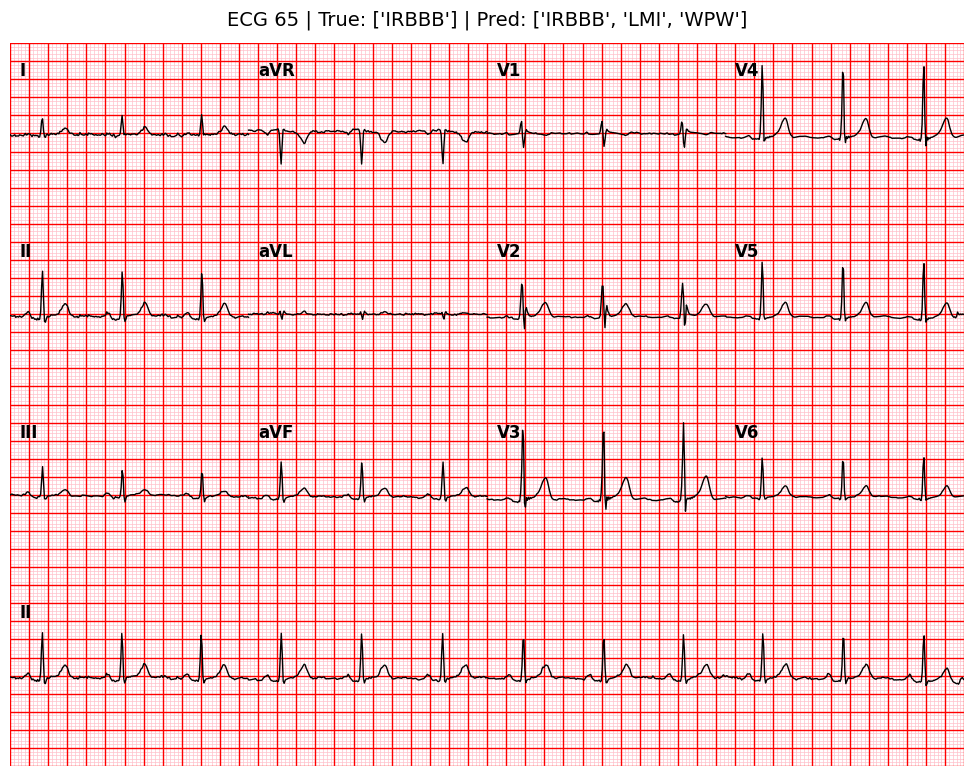

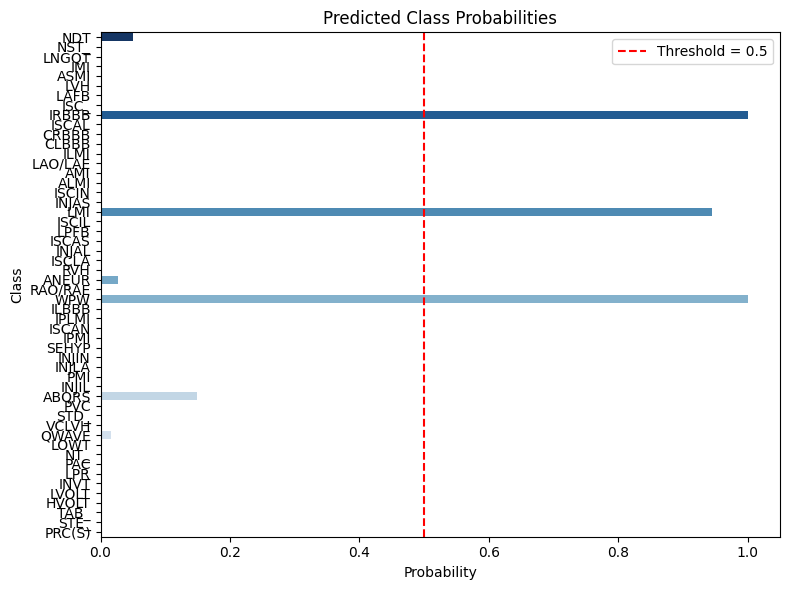


 Top Activated Prototypes:
  1. Prototype 151 (IRBBB) – Score: 11.7404
  2. Prototype 329 (LMI) – Score: 11.2983
  3. Prototype 326 (LMI) – Score: 11.2073
  4. Prototype 146 (IRBBB) – Score: 11.1761
  5. Prototype 154 (IRBBB) – Score: 11.1200

Mean Prototype Similarity per Predicted Class (using this branch-specific classifier):
  IRBBB: 10.1961 (from 18 prototype(s))
  LMI: 9.3802 (from 18 prototype(s))
  WPW: 9.6799 (from 18 prototype(s))

Predicted Classes (prob > 0.5):
  IRBBB – Prob: 1.000
  LMI – Prob: 0.944
  WPW – Prob: 1.000


In [6]:

# ---- Build prototype to class mapping ----
prototype_class_mapping = {
    int(proto_id): meta["prototype_class"]
    for proto_id, meta in prototype_metadata.items()
}

# ---- Run inference ----
if rand_ecg == True:
    X_sample, y_sample, sample_id = get_random_test_sample(test_loader)
else: 
    X_sample, y_sample, sample_id  = get_test_sample_by_id(test_loader, target_id=target_ecg_id)

true_label_indices = torch.where(y_sample == 1)[0].cpu().numpy()
true_labels = [label_mapping[i] for i in true_label_indices]

# Inference outputs
probabilities, similarity_scores = run_inference(model, X_sample)

# Get predicted labels (prob > 0.5)
predicted_label_indices = np.where(probabilities > 0.5)[0]
predicted_labels = [label_mapping[i] for i in predicted_label_indices]

# ---- Convert X_sample to (1000, 12) shape for plotting ----
x = X_sample.squeeze().cpu().numpy()

if x.shape == (12, 1000):
    raw_ecg_plot = x.T
elif x.shape == (1000, 12):
    raw_ecg_plot = x
elif x.shape == (1, 12, 1000):
    raw_ecg_plot = x.squeeze(0).T
else:
    raise ValueError(f" Unexpected shape for X_sample: {x.shape}")

# ---- Plot ECG ----
plot_ecg(
    raw_ecg_plot,
    ecg_id=f"{int(sample_id)}",
    true_labels=true_labels,
    predicted_labels=predicted_labels
)

# ---- Plot class probabilities ----
def plot_probabilities(probabilities):
    class_names = list(label_mapping.values())
    prob_df = pd.DataFrame({
        "Class": class_names,
        "Probability": probabilities
    })

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x="Probability", y="Class", data=prob_df, ax=ax, palette="Blues_r")
    ax.set_title("Predicted Class Probabilities")
    ax.axvline(0.5, color="red", linestyle="--", label="Threshold = 0.5")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_probabilities(probabilities)

# ---- Print Top Activated Prototypes ----
def get_top_prototypes(similarity_scores, top_k=5):
    top_indices = np.argsort(similarity_scores)[-top_k:][::-1]
    top_scores = similarity_scores[top_indices]
    return list(zip(top_indices, top_scores))

print("\n Top Activated Prototypes:")
top_protos = get_top_prototypes(similarity_scores, top_k=top_k)

for i, (proto_idx, score) in enumerate(top_protos):
    class_name = prototype_class_mapping.get(proto_idx, "Unknown")
    print(f"  {i+1}. Prototype {proto_idx} ({class_name}) – Score: {score:.4f}")

# ---- Compute Mean Similarity per Predicted Class ----
print("\nMean Prototype Similarity per Predicted Class (using this branch-specific classifier):")

class_similarities = {label: [] for label in predicted_labels}

for proto_idx, score in enumerate(similarity_scores):
    class_name = prototype_class_mapping.get(proto_idx)
    if class_name in class_similarities:
        class_similarities[class_name].append(score.item())

for label in predicted_labels:
    scores = class_similarities[label]
    if scores:
        print(f"  {label}: {np.mean(scores):.4f} (from {len(scores)} prototype(s))")
    else:
        print(f"  {label}: No assigned prototypes")

print("\nPredicted Classes (prob > 0.5):")
for idx in predicted_label_indices:
    print(f"  {label_mapping[idx]} – Prob: {probabilities[idx]:.3f}")


### Highlight segment of test ECG most activated by the target prototype (2D partial), or highlight rhythm strip (1D)
Do not use this code block for the 2D global branch

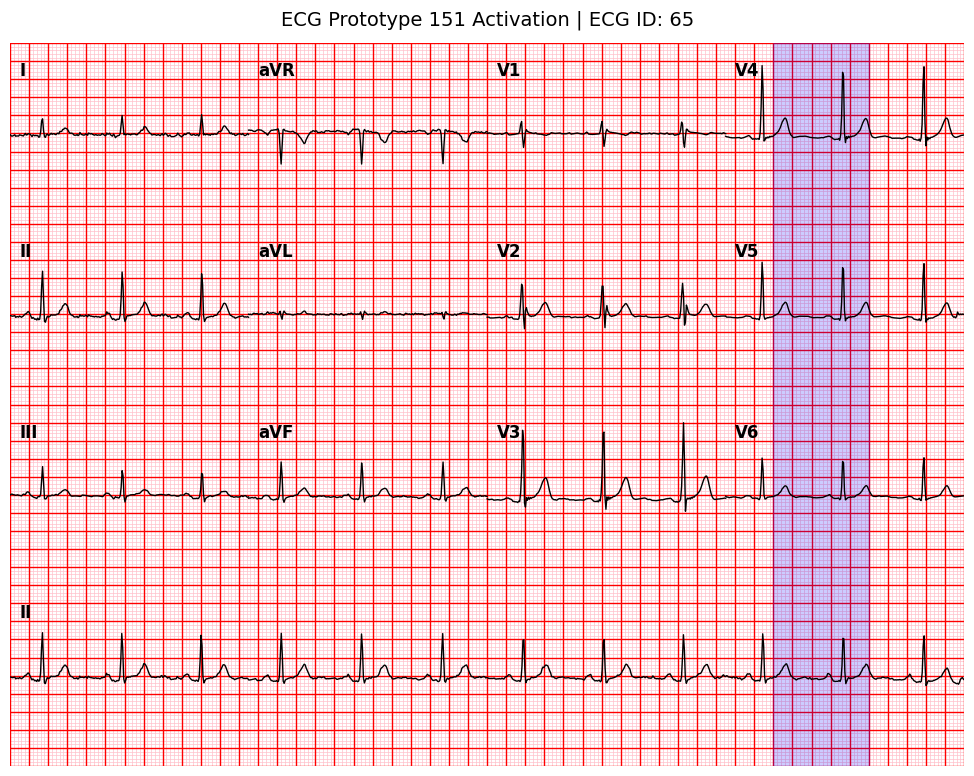

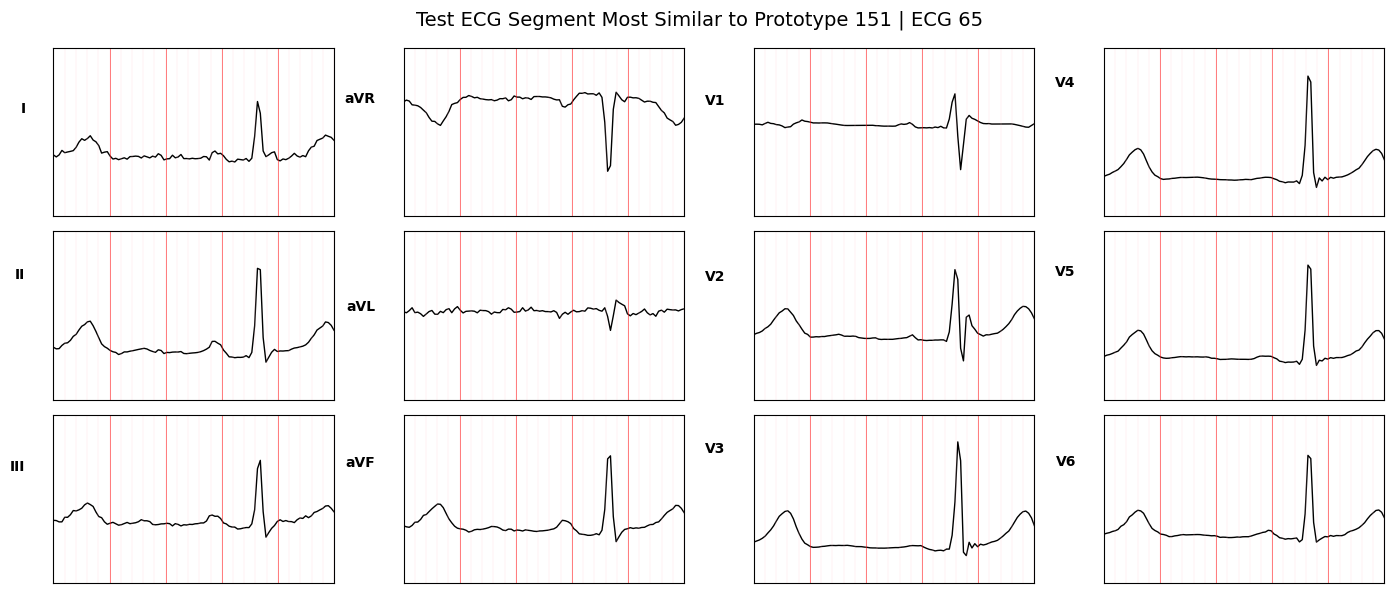

In [7]:
def highlight_test_segment_for_2dprototype(
    model,
    ecg_input,
    prototype_idx,
    proto_time_len,
    ecg_id=None,
    sampling_rate=100
):
    """
    Highlights the most activated segment for a 2D prototype and shows:
    (1) Full ECG with highlighted window
    (2) Zoomed segment with clinical 12-lead print-style layout
    """
    import matplotlib.pyplot as plt
    import numpy as np

    model.eval()
    device = next(model.parameters()).device

    if ecg_input.dim() == 3:
        ecg_input = ecg_input.unsqueeze(0)
    ecg_input = ecg_input.to(device)

    with torch.no_grad():
        _, activations = model.push_forward(ecg_input)

    # Get best-activated window
    num_windows = activations.shape[-1]
    time_scaling = 1000 / num_windows
    window_idx = torch.argmax(activations[0, prototype_idx]).item()
    raw_start = max(0, int(window_idx * time_scaling))
    raw_len = int(proto_time_len * time_scaling)
    raw_end = min(raw_start + raw_len, 1000)

    # Prepare raw ECG
    ecg_signal = ecg_input.squeeze().detach().cpu().numpy()
    if ecg_signal.shape == (1, 12, 1000):
        ecg_signal = ecg_signal.squeeze(0)
    elif ecg_signal.shape == (1, 1, 12, 1000):
        ecg_signal = ecg_signal.squeeze(0).squeeze(0)
    assert ecg_signal.shape == (12, 1000), f"Expected shape (12,1000), got {ecg_signal.shape}"

    # --- Full ECG with highlight ---
    from ecg_utils import plot_ecg
    fig = plot_ecg(
        raw_ecg=ecg_signal.T,
        ecg_id=f"Prototype {prototype_idx} Activation | ECG ID: {ecg_id}",
        rhythm_strip1='II'
    )
    ax = fig.axes[0]
    highlight_start = raw_start / sampling_rate
    highlight_end = raw_end / sampling_rate
    ax.axvspan(highlight_start, highlight_end, color='blue', alpha=0.2, zorder=1)
    plt.show()

    # --- Segment Cutout (print layout) ---
    segment = ecg_signal[:, raw_start:raw_end]
    if isinstance(segment, torch.Tensor):
        segment = segment.cpu().numpy()

    t_segment = np.linspace(highlight_start, highlight_end, segment.shape[1])
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    layout = [
        ['I', 'aVR', 'V1', 'V4'],
        ['II', 'aVL', 'V2', 'V5'],
        ['III', 'aVF', 'V3', 'V6']
    ]

    lead_idx_map = {name: i for i, name in enumerate(lead_names)}

    fig_seg, axs = plt.subplots(3, 4, figsize=(14, 6), sharex=True)
    for row in range(3):
        for col in range(4):
            lead = layout[row][col]
            i = lead_idx_map[lead]
            ax = axs[row, col]
            ax.plot(t_segment, segment[i], color='black', linewidth=1.0)
            ax.set_xlim(t_segment[0], t_segment[-1])
            ax.set_ylim(np.min(segment[i]) - 0.5, np.max(segment[i]) + 0.5)

            # Draw lead label to the left of the plot
            ax.text(t_segment[0] - 0.1, np.max(segment[i]), lead,
                    fontsize=10, fontweight='bold', ha='right', va='top')

            # ECG grid
            for x in np.arange(t_segment[0], t_segment[-1] + 0.04, 0.04):
                ax.axvline(x, color='pink', linewidth=0.3, alpha=0.5)
            for x in np.arange(t_segment[0], t_segment[-1], 0.2):
                ax.axvline(x, color='red', linewidth=0.5, alpha=0.7)

            ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    fig_seg.suptitle(
        f"Test ECG Segment Most Similar to Prototype {prototype_idx} | ECG {ecg_id}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

def highlight_rhythm_and_zoom_1d(ecg, ecg_id=None, lead="II"):
    """
    Highlights the full rhythm strip and shows a zoomed-in 10s view
    with ECG paper-style grid formatting.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure (1000, 12) shape for plotting
    if ecg.shape == (12, 1000):
        raw_ecg_for_plot = ecg.T
    elif ecg.shape == (1000, 12):
        raw_ecg_for_plot = ecg
    elif ecg.shape == (1, 12, 1000):
        raw_ecg_for_plot = ecg.squeeze(0).T
    elif ecg.shape == (1, 1, 12, 1000):
        ecg = ecg.squeeze(0)
        raw_ecg_for_plot = ecg.squeeze(0).T
    else:
        raise ValueError(f"ECG shape must be (12,1000) or (1000,12). Got {ecg.shape}")

    # ---- Full ECG with rhythm strip shown ----
    fig = plot_ecg(
        raw_ecg=raw_ecg_for_plot,
        sampling_rate=100,
        ecg_id=ecg_id,
        rhythm_strip1=lead,
    )

    # ---- Zoomed-in Rhythm Strip (Styled) ----
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    lead_idx = lead_names.index(lead)
    signal = raw_ecg_for_plot[:, lead_idx]
    t = np.linspace(0, 10, 1000)

    fig_rhythm, ax = plt.subplots(figsize=(10, 2))

    # Vertical grid lines
    for x in np.arange(0, 10.04, 0.04):
        ax.axvline(x, color='pink', linewidth=0.5, zorder=0)
    for x in np.arange(0, 10.2, 0.2):
        ax.axvline(x, color='red', linewidth=1.0, zorder=0)

    # Horizontal grid lines
    y_min, y_max = signal.min(), signal.max()
    step = 0.1  # ~1 mm at 10 mm/mV
    for y in np.arange(y_min - 0.2, y_max + 0.2, step):
        is_large = np.round(y * 10) % 5 == 0
        ax.axhline(y, color='pink' if not is_large else 'red',
                   linewidth=0.5 if not is_large else 1.0, zorder=0)

    # Plot the ECG signal
    ax.plot(t, signal, color='black', linewidth=1.0)
    ax.set_title(f"ECG {ecg_id} | Lead {lead} Rhythm Strip", fontsize=12)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(0, 10)

    plt.tight_layout()
    plt.show()

# After running inference on a selected ECG
if dimension == "2D":
    _, similarity_scores = run_inference(model, X_sample)
    similarity_map = similarity_scores.reshape(model.num_prototypes, -1)  # or just use activations directly
    highlight_test_segment_for_2dprototype(
        model=model,
        ecg_input=X_sample.unsqueeze(1),  # Should be shape (1, 1, 12, 1000)
        prototype_idx=target_prototype,
        proto_time_len=model.proto_time_len,
        ecg_id=sample_id
    )

if dimension == "1D":
    highlight_rhythm_and_zoom_1d(X_sample, ecg_id=sample_id, lead="II")